### Se va a llevar a cabo el desarrollo del entrenamiento de 3 tipos de algoritmos basados en árboles
1. Random Forest
2. XGBoost
3. CatBoost
### Para ello, a demás de entrenarlo se va a presentar la matriz de confusión y las métricas obtenidas

## 1. Carga y Exploración del Dataset

- **Carga del CSV:**  
  Se leyó el archivo CSV para tener una primera visualización de los datos.

- **Exploración inicial:**  
  - Se mostraron las primeras filas del dataset.
  - Se revisó la información general (tipos de datos, cantidad de valores nulos) y se obtuvieron estadísticas descriptivas.

---

## 2. Análisis de las Variables

- **Identificación de columnas no informativas:**  
  - `id` y `LoanNr_ChkDgt` son identificadores y no aportan valor predictivo.
  - `Name` contiene información variable sin relevancia directa, salvo que se extraiga información adicional (como sector o tipo de empresa).

- **Variables de fecha:**  
  - `ApprovalDate` y `DisbursementDate` podrían generar fuga de información si se usan tal cual.  
  - Se recomienda transformarlas (por ejemplo, extrayendo el año, mes, etc.) o descartarlas.

---

## 3. Selección de Variables Relevantes

- **Variables potencialmente importantes para predecir la aprobación de un crédito:**  
  - **Características de la empresa:**  
    - `State`, `ApprovalFY`  
    - `NoEmp` (número de empleados)  
    - `NewExist` (empresa nueva o existente)  
    - `CreateJob` y `RetainedJob` (impacto en el empleo)  
    - `FranchiseCode`  
    - `UrbanRural`  
    - `RevLineCr`, `LowDoc`  
    - `DisbursementGross`, `BalanceGross`
  
  - **Variables relacionadas con el banco y la ubicación:**  
    - `Bank`, `BankState`, `City`  
    - Pueden ser relevantes pero es necesario codificarlas o agruparlas correctamente.

---

## 4. Análisis de Correlaciones

- **Matriz de correlación:**  
  Se calculó la correlación entre las variables numéricas y la variable objetivo `Accept` para identificar cuáles tienen mayor influencia en la aprobación del crédito.
  
- **Visualización:**  
  Se utilizó un mapa de calor para visualizar la matriz de correlación y facilitar la identificación de relaciones relevantes.

---

## 5. Preprocesamiento de Datos

- **Eliminación o transformación de columnas:**  
  - Se descartaron columnas como `id`, `LoanNr_ChkDgt` y `Name` en un primer análisis.
  - Las columnas de fechas se pueden transformar o eliminar para evitar data leakage.

- **Codificación de variables categóricas:**  
  - Se aplicó one-hot encoding a variables como `State`, `Bank`, `City` y `BankState` para convertirlas en variables numéricas.

- **Tratamiento de valores nulos:**  
  - Se identificaron y gestionaron los valores nulos, por ejemplo, mediante imputación simple (o descartándolos según el caso).

---

## 6. División del Dataset

- **Separación en conjuntos de entrenamiento y validación:**  
  - Se dividió el dataset en un conjunto de entrenamiento y uno de validación, asegurando mantener la proporción de la variable objetivo (`Accept`) para una evaluación representativa del modelo.

---


## 1. Random Forest

In [1]:
import pandas as pd

# Cargar el dataset de entrenamiento
df = pd.read_csv('../../../data/processed/df_train.csv')

# Mostrar las primeras filas
# print(df.head())
# Información general (tipos de datos y valores nulos)
#print(df.info())

# Estadísticas descriptivasÇ
# print(df.describe(include='all'))
df

,id,LoanNr_ChkDgt,Name,City,State,Bank,BankState,ApprovalDate,ApprovalFY,NoEmp,...,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,Accept
0,bd9d6267ec5,1523195006,"P-SCAPE LAND DESIGN, LLC",NORTHFIELD,OH,CITIZENS BANK NATL ASSOC,RI,2005-11-01,2006,2,...,0,2,0,1,0.0,0.0,2005-12-31,8000.0,0.0,1
1,9eebf6d8098,1326365010,The Fresh & Healthy Catering C,CANTON,OH,"FIRSTMERIT BANK, N.A.",OH,2005-06-06,2005,2,...,1,2,1,1,0.0,0.0,2005-07-31,166000.0,0.0,1
2,83806858500,6179584001,AARON MASON & HOWE LLC,SAWYERWOOD,OH,"PNC BANK, NATIONAL ASSOCIATION",OH,2003-03-18,2003,2,...,4,2,1,2,1.0,0.0,2003-03-31,25000.0,0.0,1
3,a21ab9cb3af,8463493009,MID OHIO CAR WASH,COLUMBUS,OH,THE HUNTINGTON NATIONAL BANK,OH,1995-06-28,1995,2,...,0,0,1,0,0.0,0.0,1996-01-31,220100.0,0.0,1
4,883b5e5385e,3382225007,Bake N Brew LLC,NEWARK,OH,THE HUNTINGTON NATIONAL BANK,OH,2009-04-16,2009,0,...,0,0,0,1,0.0,0.0,2009-05-31,25000.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22827,4f9443d2a46,1573725008,"SIBILA RACE ENGINEERING, INC",MASSILLON,OH,CITIZENS BANK NATL ASSOC,RI,2005-12-09,2006,1,...,0,1,0,1,0.0,0.0,2005-12-31,70000.0,0.0,1
22828,798db2753a7,2011184008,ENVIRO SHIELD POWER WASHING,SPRINGBORO,OH,"PNC BANK, NATIONAL ASSOCIATION",OH,1998-04-27,1998,2,...,0,0,1,0,0.0,1.0,1998-05-31,30000.0,0.0,1
22829,ddb3c5e9bff,4082983001,"MAINLINE TRCK&TRAILR SRVC, INC",BEDFORD,OH,GROWTH CAPITAL CORP.,OH,1990-05-09,1990,16,...,6,10,1,0,0.0,0.0,1991-02-13,92000.0,0.0,1
22830,407200a5dfe,7783283010,TIN BOX STUDIO,CINCINNATI,OH,KEYBANK NATIONAL ASSOCIATION,OH,1994-11-10,1995,1,...,0,0,1,0,0.0,1.0,1995-01-31,20000.0,0.0,1


In [2]:
approval_by_city = df.groupby('City')['Accept'].mean().sort_values(ascending=False) 
print("\nTasa de aprobación por ciudad:") 
print(approval_by_city.head(10))


Tasa de aprobación por ciudad:
City
ABERDEEN            1.0
HUNTSVILLE          1.0
SOUTH VIENNA        1.0
SOUTH RUSSELL       1.0
KIMBOLTON           1.0
SOUTH CHARLESTON    1.0
SOUTH BLOOMFIELD    1.0
SOUTH AMHERST       1.0
KIPTON              1.0
KIRKERSVILLE        1.0
Name: Accept, dtype: float64


Preprocesamos los datos

In [3]:
cols_to_drop = ['id', 'LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'DisbursementDate', 'State']
df_clean = df.drop(columns=cols_to_drop)
# City, State, Name, Bank, BankState, ApprovalDate, , ApprovalDate, ApprovalFY, NoEmp, NewExist, UrbanRural,DisbursementDate, DisbursementGross

#Codif variables categóricas
df_clean = pd.get_dummies(df_clean, columns=['Bank', 'City', 'BankState'], drop_first=True)

print(df_clean.isnull().sum())
# Ejemplo simple: imputar nulos con 0 (ajusta según cada variable)
df_clean.fillna(0, inplace=True)

# Mostrar la distribución original de la variable target 'Accept'
print("Distribución original de 'Accept':")
print(df_clean['Accept'].value_counts())

# Balancear el DataFrame:
# Supongamos que la clase 0 (rechazados) es la minoritaria y la clase 1 (aceptados) es la mayoritaria.

# Extraer los DataFrames de cada clase
df_accept_0 = df_clean[df_clean['Accept'] == 0]
df_accept_1 = df_clean[df_clean['Accept'] == 1]

# Realizar un muestreo aleatorio de la clase mayoritaria (1) para igualar el número de la minoritaria (0)
n_minority = len(df_accept_0)
df_accept_1_under = df_accept_1.sample(n=n_minority, random_state=42)

# Combinar ambas clases y mezclar los registros
df_balanced = pd.concat([df_accept_0, df_accept_1_under]).sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar la nueva distribución
print("Distribución balanceada de 'Accept':")
print(df_balanced['Accept'].value_counts())

# df_balanced es el DataFrame final balanceado
df_clean = df_balanced

ApprovalFY       0
NoEmp            0
NewExist        14
CreateJob        0
RetainedJob      0
                ..
BankState_VA     0
BankState_WA     0
BankState_WI     0
BankState_WV     0
BankState_WY     0
Length: 1519, dtype: int64
Distribución original de 'Accept':
Accept
1    19001
0     3831
Name: count, dtype: int64
Distribución balanceada de 'Accept':
Accept
1    3831
0    3831
Name: count, dtype: int64


División del dataset

In [4]:
from sklearn.model_selection import train_test_split

X = df_clean.drop('Accept', axis=1)
y = df_clean['Accept']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Entrenamiento Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier

class_weights = {0: 15, 1: 1}  # Ajusta estos valores según tus datos
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 15, 1: 1}, random_state=42)

Evaluación

In [6]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

y_pred = rf.predict(X_test)

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

print(f"Clase 0 SON CRÉDITOS RECHAZADOS y Clase 1 son CRÉDITOS ACEPTADOS")

# Reporte de Clasificación (precision, recall, f1-score, etc.)
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Calcular el Macro F1-Score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1-Score: {macro_f1:.2f}")

Matriz de Confusión:
[[562 205]
 [267 499]]
Clase 0 SON CRÉDITOS RECHAZADOS y Clase 1 son CRÉDITOS ACEPTADOS
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.68      0.73      0.70       767
           1       0.71      0.65      0.68       766

    accuracy                           0.69      1533
   macro avg       0.69      0.69      0.69      1533
weighted avg       0.69      0.69      0.69      1533

Macro F1-Score: 0.69


## Y esto es para subirlo al kaggle

In [7]:
import pandas as pd
import datetime

# Cargar el dataset de test
df_test = pd.read_csv("../../../data/processed/df_test_nolabel.csv")

# --- Preprocesamiento ---
# Debes replicar exactamente los pasos que aplicaste al entrenamiento.
# 1. Eliminar las columnas irrelevantes (como hiciste en entrenamiento)
cols_to_drop = ['id', 'LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'DisbursementDate', 'State']
df_test_clean = df_test.drop(columns=cols_to_drop)

# 2. Aplicar one-hot encoding a las columnas categóricas que usaste en entrenamiento:
#    En tu entrenamiento usaste: ['Bank', 'City', 'BankState'] con drop_first=True.
df_test_clean = pd.get_dummies(df_test_clean, columns=['Bank', 'City', 'BankState'], drop_first=True)

# 3. Imputar valores nulos (igual que en entrenamiento)
df_test_clean.fillna(0, inplace=True)

# --- Alinear las features ---
# Durante el entrenamiento, tu DataFrame final balanceado 'df_clean' tenía un cierto conjunto de columnas (features).
# Asumiendo que entrenaste el modelo con:
#   X_train = df_clean.drop('Accept', axis=1)
# Guarda la lista de features de entrenamiento:
features = list(df_clean.drop('Accept', axis=1).columns)
print("Número de features en entrenamiento:", len(features))

# Reindexa el DataFrame de test para que tenga exactamente las mismas columnas, llenando con 0 las que no estén.
df_test_clean = df_test_clean.reindex(columns=features, fill_value=0)
print("Número de features en test:", df_test_clean.shape[1])

# --- Predicción ---
# Extrae el array de features del test
X_test = df_test_clean.values

# Realiza las predicciones usando tu modelo entrenado (en este caso, 'rf')
df_test['Accept'] = rf.predict(X_test)

# Asegúrate de que la columna 'Accept' sea de tipo entero
df_test['Accept'] = df_test['Accept'].astype(int)

# --- Exportar Submission ---
# Crea el archivo CSV con las columnas requeridas: 'id' y 'Accept'
filename = f"XGBOOST_{datetime.datetime.now().strftime('%Y%m%d_%H_%M_%S')}.csv"
df_test.to_csv(filename, columns=['id', 'Accept'], index=False)

print("Archivo de submission 'my-model.csv' generado correctamente.")


Número de features en entrenamiento: 1518
Número de features en test: 1518


/opt/com.debugpoint/Anaconda/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Archivo de submission 'my-model.csv' generado correctamente.


### Modificando los parámetros de configuración del modelo

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 1. Cargar el dataset y preprocesar
df = pd.read_csv('../../../data/processed/df_train.csv')

#################################Preprocesado##########################
cols_to_drop = ['id', 'LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'DisbursementDate', 'State']
df_clean = df.drop(columns=cols_to_drop)
# City, State, Name, Bank, BankState, ApprovalDate, , ApprovalDate, ApprovalFY, NoEmp, NewExist, UrbanRural,DisbursementDate, DisbursementGross
#Codif variables categóricas
df_clean = pd.get_dummies(df_clean, columns=['Bank', 'City', 'BankState'], drop_first=True)
# Ejemplo simple: imputar nulos con 0 (ajusta según cada variable)
df_clean.fillna(0, inplace=True)
# Balancear el DataFrame:
# Extraer los DataFrames de cada clase
df_accept_0 = df_clean[df_clean['Accept'] == 0]
df_accept_1 = df_clean[df_clean['Accept'] == 1]
# Realizar un muestreo aleatorio de la clase mayoritaria (1) para igualar el número de la minoritaria (0)
n_minority = len(df_accept_0)
df_accept_1_under = df_accept_1.sample(n=n_minority, random_state=42)
# Combinar ambas clases y mezclar los registros
df_balanced = pd.concat([df_accept_0, df_accept_1_under]).sample(frac=1, random_state=42).reset_index(drop=True)
# df_balanced es el DataFrame final balanceado
df_clean = df_balanced
X = df_clean.drop('Accept', axis=1)
y = df_clean['Accept']

#################################Entrenamiento del modelo##########################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#class_weights = {0: 15, 1: 1}  # Me emporan las métricas mucho 
rf = RandomForestClassifier(
    criterion = 'gini', #entropy (bien) | log_loss (bien)  | gini (default)
    n_estimators=400,          # Más árboles para mayor estabilidad, NO PUEDO SUBIRLO MÁS PORQUE NO ALCANZA MÁS DE 0.7
    max_depth=80,              # Limita la profundidad para controlar el sobreajuste, NO PUEDO SUBIRLO MÁS PORQUE NO ALCANZA MÁS DE 0.7
    max_features='sqrt',       # log2 | sqrt (me da mejores resultados)
    #class_weight=class_weights
    # bootstrap=True           # Usa muestreo con reemplazo

)
rf.fit(X_train, y_train)

###################################Métricas##########################################3
y_pred = rf.predict(X_test)

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)
print(f"Clase 0 SON CRÉDITOS RECHAZADOS y Clase 1 son CRÉDITOS ACEPTADOS")
# Reporte de Clasificación (precision, recall, f1-score, etc.)
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))
# Calcular el Macro F1-Score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1-Score: {macro_f1:.2f}")

Matriz de Confusión:
[[517 250]
 [236 530]]
Clase 0 SON CRÉDITOS RECHAZADOS y Clase 1 son CRÉDITOS ACEPTADOS
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       767
           1       0.68      0.69      0.69       766

    accuracy                           0.68      1533
   macro avg       0.68      0.68      0.68      1533
weighted avg       0.68      0.68      0.68      1533

Macro F1-Score: 0.68


## Ahora pruebo el Grid para mejorarlo, no se mejora mucho pero hay que darle una pensada a las columnas

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer

# 1. Cargar el dataset y preprocesar
df = pd.read_csv('../../../data/processed/df_train.csv')

# Eliminar columnas irrelevantes
cols_to_drop = ['id', 'LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'DisbursementDate', 'State']
df_clean = df.drop(columns=cols_to_drop)

# Aplicar one-hot encoding a las columnas categóricas: Bank, City y BankState
df_clean = pd.get_dummies(df_clean, columns=['Bank', 'City', 'BankState'], drop_first=True)

# Imputar valores nulos
df_clean.fillna(0, inplace=True)

# Balancear el DataFrame (undersampling de la clase mayoritaria)
df_accept_0 = df_clean[df_clean['Accept'] == 0]
df_accept_1 = df_clean[df_clean['Accept'] == 1]
n_minority = len(df_accept_0)
df_accept_1_under = df_accept_1.sample(n=n_minority, random_state=42)
df_balanced = pd.concat([df_accept_0, df_accept_1_under]).sample(frac=1, random_state=42).reset_index(drop=True)
df_clean = df_balanced

# 2. Separar features y target
X = df_clean.drop('Accept', axis=1)
y = df_clean['Accept']

# 3. Dividir en conjuntos de entrenamiento y prueba (stratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Definir el grid de hiperparámetros para RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

# Crear un scorer basado en el Macro F1-Score para evaluar el balance entre las clases
scorer = make_scorer(f1_score, average='macro')

# 5. Configurar y ejecutar GridSearchCV
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight={0: 15, 1: 1}, n_jobs=-1),
    param_grid=param_grid,
    scoring=scorer,
    cv=3,
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)

print("Mejores parámetros encontrados:")
print(grid_rf.best_params_)

# 6. Evaluar el mejor modelo en el conjunto de prueba
best_rf = grid_rf.best_estimator_
y_pred = best_rf.predict(X_test)

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))
print("Macro F1-Score:", f1_score(y_test, y_pred, average='macro'))


### Este es un random que tengo que darle una pensada

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer
from sklearn.feature_selection import RFE

# 1. Cargar el dataset y preprocesar
df = pd.read_csv('../../../data/processed/df_train.csv')
cols_to_drop = ['id', 'LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'DisbursementDate', 'State']
df_clean = df.drop(columns=cols_to_drop)
df_clean = pd.get_dummies(df_clean, columns=['Bank', 'City', 'BankState'], drop_first=True)
df_clean.fillna(0, inplace=True)

# Balancear el DataFrame (undersampling de la clase mayoritaria)
df_accept_0 = df_clean[df_clean['Accept'] == 0]
df_accept_1 = df_clean[df_clean['Accept'] == 1]
n_minority = len(df_accept_0)
df_accept_1_under = df_accept_1.sample(n=n_minority, random_state=42)
df_balanced = pd.concat([df_accept_0, df_accept_1_under]).sample(frac=1, random_state=42).reset_index(drop=True)
df_clean = df_balanced

# 2. Separar features y target
X = df_clean.drop('Accept', axis=1)
y = df_clean['Accept']

# 3. Dividir en entrenamiento y prueba (stratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Selección de características con RFE
# Usamos un RandomForestClassifier base para estimar la importancia de features
base_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0:15, 1:1})
# Seleccionaremos, por ejemplo, las 100 mejores features (ajusta según el número total de columnas)
rfe_selector = RFE(estimator=base_rf, n_features_to_select=100, step=0.1)
rfe_selector.fit(X_train, y_train)

# Reducir X_train y X_test a las features seleccionadas
X_train_rfe = X_train.loc[:, rfe_selector.support_]
X_test_rfe = X_test.loc[:, rfe_selector.support_]

print("Número de features seleccionadas:", X_train_rfe.shape[1])

# 5. Definir el grid de hiperparámetros para el RandomForest con las features seleccionadas
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

scorer = make_scorer(f1_score, average='macro')

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight={0:15, 1:1}, n_jobs = 10),
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1
)
grid_rf.fit(X_train_rfe, y_train)

print("Mejores parámetros encontrados:")
print(grid_rf.best_params_)

# 6. Evaluar el mejor modelo en el conjunto de prueba
best_rf = grid_rf.best_estimator_
y_pred = best_rf.predict(X_test_rfe)

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))
print("Macro F1-Score:", f1_score(y_test, y_pred, average='macro'))


## 2. XGBoost con los params tops del Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# 1. Cargar el dataset de entrenamiento
df = pd.read_csv('../../../data/processed/df_train.csv')

#############################Procesado##################################################
cols_to_drop = ['id', 'LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'DisbursementDate', 'State']
df_clean = df.drop(columns=cols_to_drop)
# City, State, Name, Bank, BankState, ApprovalDate, ApprovalFY, NoEmp, NewExist, UrbanRural,DisbursementDate, DisbursementGross
#Codif variables categóricas
df_clean = pd.get_dummies(df_clean, columns=['Bank', 'City', 'BankState'], drop_first=True)
# Ejemplo simple: imputar nulos con 0 (ajusta según cada variable)
df_clean.fillna(0, inplace=True)
# Balancear el DataFrame:
# Extraer los DataFrames de cada clase
df_accept_0 = df_clean[df_clean['Accept'] == 0]
df_accept_1 = df_clean[df_clean['Accept'] == 1]
# Realizar un muestreo aleatorio de la clase mayoritaria (1) para igualar el número de la minoritaria (0)
n_minority = len(df_accept_0)
df_accept_1_under = df_accept_1.sample(n=n_minority, random_state=42)
# Combinar ambas clases y mezclar los registros
df_balanced = pd.concat([df_accept_0, df_accept_1_under]).sample(frac=1, random_state=42).reset_index(drop=True)
# df_balanced es el DataFrame final balanceado
df_clean = df_balanced
X = df_clean.drop('Accept', axis=1)
y = df_clean['Accept']
###############################################################################
# 5. Dividir el dataset de forma estratificada (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Crear pesos de muestra para la clase deseada
# Se asigna un peso de 15 a la clase 0 (créditos rechazados) y 1 a la clase 1 (créditos aceptados)
sample_weights = y_train.map({0: 15, 1: 1})

# 7. Inicializar y entrenar el modelo XGBoost
xgb = XGBClassifier( 
                    random_state=42, 
                    n_estimators=400,          # Más árboles para mayor estabilidad, NO PUEDO SUBIRLO MÁS PORQUE NO ALCANZA MÁS DE 0.7
                    max_depth=80,              # Limita la profundidad para controlar el sobreajuste, NO PUEDO SUBIRLO MÁS PORQUE NO ALCANZA MÁS DE 0.7
                    max_features='sqrt',
                    use_label_encoder=False, 
                    eval_metric='logloss')
xgb.fit(X_train, y_train, sample_weight=sample_weights)

# 8. Realizar predicciones en el conjunto de prueba
y_pred = xgb.predict(X_test)

# 9. Evaluar el modelo

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

print("Clase 0 SON CRÉDITOS RECHAZADOS y Clase 1 son CRÉDITOS ACEPTADOS")

# Reporte de Clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Calcular el Macro F1-Score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1-Score: {macro_f1:.2f}")


No me funciona catboost porque estoy usando la versión 3.13.1 y tiene que ser inferior a la versión 3.13

## 3. CatBoost

In [1]:
%pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [160]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Cargar el dataset y preprocesar
df = pd.read_csv('../../../data/processed/df_train.csv')


In [161]:
# Balancear el DataFrame (undersampling de la clase mayoritaria)
df_accept_0 = df[df['Accept'] == 0]
df_accept_1 = df[df['Accept'] == 1]
n_minority = len(df_accept_0)
df_accept_1_under = df_accept_1.sample(n=n_minority, random_state=42)
df_balanced = pd.concat([df_accept_0, df_accept_1_under]).sample(frac=1, random_state=42).reset_index(drop=True)
df = df_balanced

X = df.copy().drop(columns=["id","LoanNr_ChkDgt","Name","State","Bank","Accept"])  # Características
y = df.copy()["Accept"]  # Variable objetivo (aceptación del crédito)

# CatBoost no acepta valores nulos en las categorías - hay que tomar decisiones
X.isnull().sum()
df_train = df.drop(columns=["id","LoanNr_ChkDgt","Name","BalanceGross","State","Bank"])
df_train



,City,BankState,ApprovalDate,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,Accept
0,WILLOUGHBY,RI,2004-10-18,2005,6,0.0,0,6,1,1,1.0,0.0,2005-01-31,16437.0,1
1,AKRON,DE,2002-09-05,2002,10,1.0,0,0,1,1,0.0,1.0,2003-03-31,109200.0,0
2,BRUNSWICK,IL,1990-03-29,1990,4,0.0,0,0,1,0,0.0,0.0,1990-07-31,365000.0,0
3,TIPP CITY,OH,1993-07-08,1993,64,0.0,21,43,1,0,0.0,0.0,1993-11-17,750000.0,1
4,DAYTON,IL,2002-09-13,2002,2,0.0,18,2,1,1,1.0,0.0,2002-11-30,141472.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,LOUDONVILLE,OH,2004-10-22,2005,2,0.0,0,0,1,2,1.0,0.0,2004-10-31,13895.0,1
7658,MENTOR,OH,1987-02-25,1987,21,0.0,6,15,0,0,0.0,0.0,1987-07-15,94000.0,1
7659,BAY VILLAGE,IL,2005-11-03,2006,1,1.0,2,2,0,1,1.0,0.0,2005-12-31,33400.0,0
7660,WILLOUGHBY,RI,2004-10-12,2005,4,0.0,0,4,1,1,1.0,0.0,2005-06-30,203102.0,1


In [162]:
df_train.dropna()

,City,BankState,ApprovalDate,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,Accept
0,WILLOUGHBY,RI,2004-10-18,2005,6,0.0,0,6,1,1,1.0,0.0,2005-01-31,16437.0,1
1,AKRON,DE,2002-09-05,2002,10,1.0,0,0,1,1,0.0,1.0,2003-03-31,109200.0,0
2,BRUNSWICK,IL,1990-03-29,1990,4,0.0,0,0,1,0,0.0,0.0,1990-07-31,365000.0,0
3,TIPP CITY,OH,1993-07-08,1993,64,0.0,21,43,1,0,0.0,0.0,1993-11-17,750000.0,1
4,DAYTON,IL,2002-09-13,2002,2,0.0,18,2,1,1,1.0,0.0,2002-11-30,141472.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,LOUDONVILLE,OH,2004-10-22,2005,2,0.0,0,0,1,2,1.0,0.0,2004-10-31,13895.0,1
7658,MENTOR,OH,1987-02-25,1987,21,0.0,6,15,0,0,0.0,0.0,1987-07-15,94000.0,1
7659,BAY VILLAGE,IL,2005-11-03,2006,1,1.0,2,2,0,1,1.0,0.0,2005-12-31,33400.0,0
7660,WILLOUGHBY,RI,2004-10-12,2005,4,0.0,0,4,1,1,1.0,0.0,2005-06-30,203102.0,1


In [163]:
valores_newexist = df_train["NewExist"].value_counts(dropna=False)
print(valores_newexist)

# Filtrar y contar las filas con NewExist nulo y Accept 0
num_filas = df_train[df_train["NewExist"].isna() & (df_train["Accept"] == 0)].shape[0]
num_filas # como es solo una, podemos eliminar las nulas en NewExist del dataset. También podemos sustituir por el mayoritario

moda = df_train["NewExist"].mode()[0]
df_train["NewExist"].fillna(moda, inplace=True)
df_train["NewExist"] = df_train["NewExist"].astype(int)


NewExist
0.0    5257
1.0    2401
NaN       4
Name: count, dtype: int64


In [164]:
# Categoria RevLineCr

valores_rev = df_train["RevLineCr"].value_counts(dropna=False)
print(valores_rev)

# Filtrar y contar las filas con NewExist nulo y Accept 0
num_filas = df_train[df_train["RevLineCr"].isna() & (df_train["Accept"] == 0)]
num_filas # como es solo una, podemos eliminar las nulas en RevLineCr del dataset. También podemos sustituir por el mayoritario

moda = df_train["RevLineCr"].mode()[0]
df_train["RevLineCr"].fillna(moda, inplace=True)
df_train["RevLineCr"] = df_train["RevLineCr"].astype(int)


RevLineCr
0.0    5121
1.0    2525
NaN      16
Name: count, dtype: int64


In [165]:
# Categoria LowDoc

valores_lowdoc = df_train["LowDoc"].value_counts(dropna=False)
print(valores_lowdoc)

# Filtrar y contar las filas con NewExist nulo y Accept 0
num_filas = df_train[df_train["LowDoc"].isna() & (df_train["Accept"] == 0)].shape[0]
num_filas # Hay veinticuatro valores de 3000 que son accept y nulos, rellenamos con el mayoritario 

moda = df_train["LowDoc"].mode()[0]
df_train["LowDoc"].fillna(moda, inplace=True)
df_train["LowDoc"] = df_train["LowDoc"].astype(int)


LowDoc
0.0    6739
1.0     888
NaN      35
Name: count, dtype: int64


In [166]:
# Categoria Disbursment Date
# Filtrar y contar las filas con NewExist nulo y Accept 0
num_filas = df_train[df_train["DisbursementDate"].isna() & (df_train["Accept"] == 0)].shape[0]
print(num_filas)

8


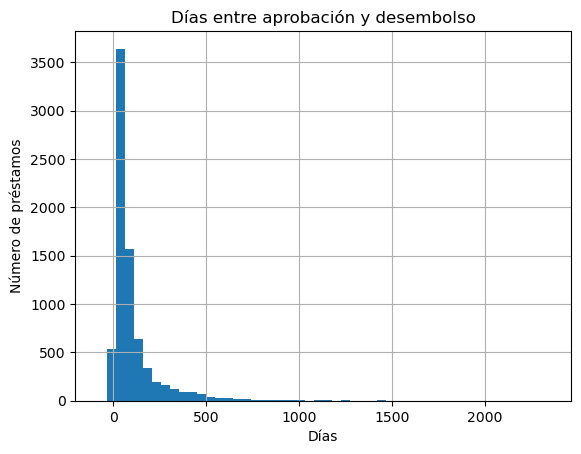

In [167]:
df_train["ApprovalDate"] = pd.to_datetime(df_train["ApprovalDate"])
df_train["DisbursementDate"] = pd.to_datetime(df_train["DisbursementDate"])

df_train["DaysToDisburse"] = (df_train["DisbursementDate"] - df_train["ApprovalDate"]).dt.days

import matplotlib.pyplot as plt

df_train["DaysToDisburse"].hist(bins=50)
plt.title("Días entre aprobación y desembolso")
plt.xlabel("Días")
plt.ylabel("Número de préstamos")
plt.show()


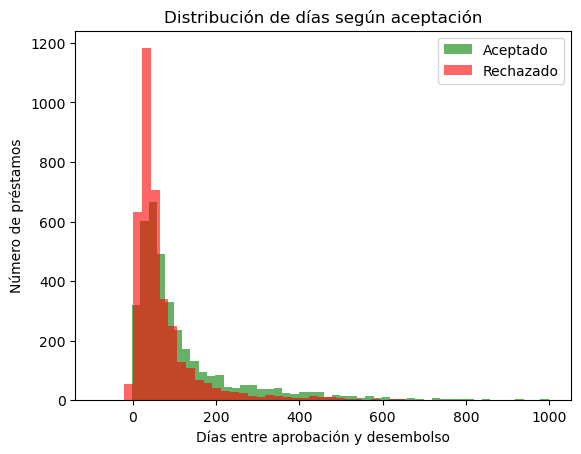

In [168]:
import matplotlib.pyplot as plt

# Filtrar valores razonables (por ejemplo, quitar los días > 1000 para ver mejor la forma)
df_filtered = df_train[df_train["DaysToDisburse"] < 1000]

# Separar por clase
accepted = df_filtered[df_filtered["Accept"] == 1]["DaysToDisburse"]
rejected = df_filtered[df_filtered["Accept"] == 0]["DaysToDisburse"]

# Plot
plt.hist(accepted, bins=50, alpha=0.6, label="Aceptado", color='green')
plt.hist(rejected, bins=50, alpha=0.6, label="Rechazado", color='red')
plt.xlabel("Días entre aprobación y desembolso")
plt.ylabel("Número de préstamos")
plt.title("Distribución de días según aceptación")
plt.legend()
plt.show()


In [169]:
# Calcular percentiles de DaysToDisburse
percentiles = df_train["DaysToDisburse"].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0])

# Mostrar
print("Percentiles de DaysToDisburse:")
print(percentiles)


Percentiles de DaysToDisburse:
0.00     -84.00
0.25      31.00
0.50      55.00
0.75     110.00
0.90     243.80
0.95     386.80
0.99     765.74
1.00    2343.00
Name: DaysToDisburse, dtype: float64


Ambas fechas se encuentran bastante próximas. Se contempla rellenar DisbursmentDate con los valores de ApprovalDate y crear la variable DisbursmentFY, pero se considera más adecuado utilizar la desviación típica, ya que al observar el número de veces que se cambia de año, consideramos que es un número elevado como para tomar riesgos.

In [170]:
from pandas import Timedelta

std_days = df_train["DaysToDisburse"].std()
std_days

# Rellenar los nulos con ApprovalDate + std (en días)
df_train["DisbursementDate"] = df_train["DisbursementDate"].fillna(
    df_train["ApprovalDate"] + Timedelta(days=std_days)
)


In [171]:
X = df_train.drop(columns=["ApprovalDate","Accept"])  # Características
y = df_train["Accept"]  # Variable objetivo (aceptación del crédito)
X.isnull().sum()

City                  0
BankState             0
ApprovalFY            0
NoEmp                 0
NewExist              0
CreateJob             0
RetainedJob           0
FranchiseCode         0
UrbanRural            0
RevLineCr             0
LowDoc                0
DisbursementDate      0
DisbursementGross     0
DaysToDisburse       19
dtype: int64

In [172]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662 entries, 0 to 7661
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   City               7662 non-null   object        
 1   BankState          7662 non-null   object        
 2   ApprovalFY         7662 non-null   int64         
 3   NoEmp              7662 non-null   int64         
 4   NewExist           7662 non-null   int64         
 5   CreateJob          7662 non-null   int64         
 6   RetainedJob        7662 non-null   int64         
 7   FranchiseCode      7662 non-null   int64         
 8   UrbanRural         7662 non-null   int64         
 9   RevLineCr          7662 non-null   int64         
 10  LowDoc             7662 non-null   int64         
 11  DisbursementDate   7662 non-null   datetime64[ns]
 12  DisbursementGross  7662 non-null   float64       
 13  DaysToDisburse     7643 non-null   float64       
dtypes: datet

In [173]:
df_train

,City,BankState,ApprovalDate,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,Accept,DaysToDisburse
0,WILLOUGHBY,RI,2004-10-18,2005,6,0,0,6,1,1,1,0,2005-01-31,16437.0,1,105.0
1,AKRON,DE,2002-09-05,2002,10,1,0,0,1,1,0,1,2003-03-31,109200.0,0,207.0
2,BRUNSWICK,IL,1990-03-29,1990,4,0,0,0,1,0,0,0,1990-07-31,365000.0,0,124.0
3,TIPP CITY,OH,1993-07-08,1993,64,0,21,43,1,0,0,0,1993-11-17,750000.0,1,132.0
4,DAYTON,IL,2002-09-13,2002,2,0,18,2,1,1,1,0,2002-11-30,141472.0,0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,LOUDONVILLE,OH,2004-10-22,2005,2,0,0,0,1,2,1,0,2004-10-31,13895.0,1,9.0
7658,MENTOR,OH,1987-02-25,1987,21,0,6,15,0,0,0,0,1987-07-15,94000.0,1,140.0
7659,BAY VILLAGE,IL,2005-11-03,2006,1,1,2,2,0,1,1,0,2005-12-31,33400.0,0,58.0
7660,WILLOUGHBY,RI,2004-10-12,2005,4,0,0,4,1,1,1,0,2005-06-30,203102.0,1,261.0


In [174]:
from sklearn.model_selection import train_test_split

X = df_train.drop(columns=["DisbursementDate","ApprovalDate","Accept"])  # Características
y = df["Accept"]  # Variable objetivo (aceptación del crédito)
# División en conjunto de test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [175]:
# Categorical 
cat_features = ["City","BankState","NoEmp","NewExist","CreateJob","RetainedJob","UrbanRural","RevLineCr"]

# Crear los pools de CatBoost
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)


In [176]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.03,
    depth=10,
    eval_metric="F1",
    auto_class_weights="Balanced",
    random_seed=42,
    verbose=100
)


In [177]:
model.fit(train_pool)

0:	learn: 0.6718292	total: 60.4ms	remaining: 48.3s
100:	learn: 0.7821824	total: 1.49s	remaining: 10.3s
200:	learn: 0.8343808	total: 2.92s	remaining: 8.7s
300:	learn: 0.8761401	total: 4.4s	remaining: 7.29s
400:	learn: 0.9061641	total: 5.87s	remaining: 5.84s
500:	learn: 0.9314882	total: 7.37s	remaining: 4.4s
600:	learn: 0.9505373	total: 8.79s	remaining: 2.91s
700:	learn: 0.9663196	total: 10.4s	remaining: 1.47s
799:	learn: 0.9782494	total: 12.1s	remaining: 0us


In [178]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predicciones
y_pred = model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClasificación:\n", classification_report(y_test, y_pred))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7077625570776256

Clasificación:
               precision    recall  f1-score   support

           0       0.72      0.71      0.71       790
           1       0.70      0.71      0.70       743

    accuracy                           0.71      1533
   macro avg       0.71      0.71      0.71      1533
weighted avg       0.71      0.71      0.71      1533


Matriz de confusión:
 [[561 229]
 [219 524]]


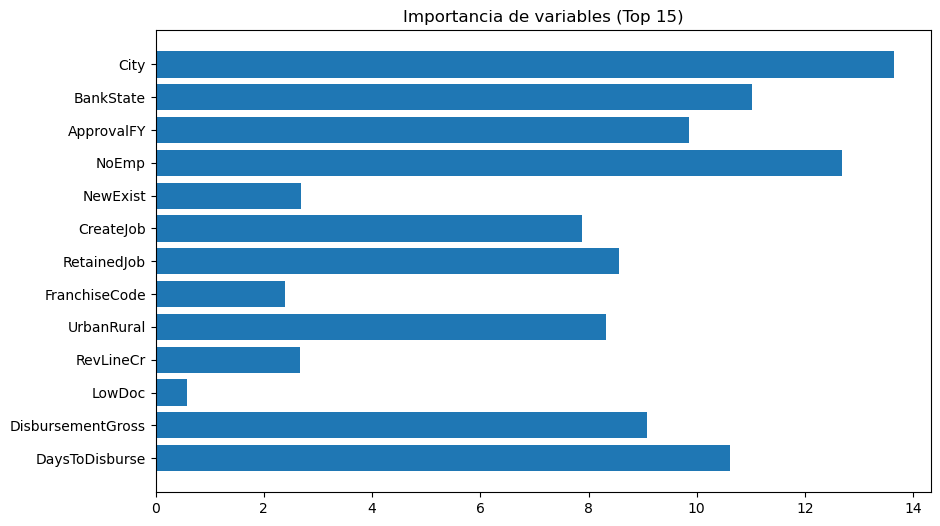

In [179]:
import matplotlib.pyplot as plt

feature_importance = model.get_feature_importance()
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names[:15], feature_importance[:15])
plt.title("Importancia de variables (Top 15)")
plt.gca().invert_yaxis()
plt.show()


### Búsqueda de threshold para F1

In [180]:

df_train

,City,BankState,ApprovalDate,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,Accept,DaysToDisburse
0,WILLOUGHBY,RI,2004-10-18,2005,6,0,0,6,1,1,1,0,2005-01-31,16437.0,1,105.0
1,AKRON,DE,2002-09-05,2002,10,1,0,0,1,1,0,1,2003-03-31,109200.0,0,207.0
2,BRUNSWICK,IL,1990-03-29,1990,4,0,0,0,1,0,0,0,1990-07-31,365000.0,0,124.0
3,TIPP CITY,OH,1993-07-08,1993,64,0,21,43,1,0,0,0,1993-11-17,750000.0,1,132.0
4,DAYTON,IL,2002-09-13,2002,2,0,18,2,1,1,1,0,2002-11-30,141472.0,0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,LOUDONVILLE,OH,2004-10-22,2005,2,0,0,0,1,2,1,0,2004-10-31,13895.0,1,9.0
7658,MENTOR,OH,1987-02-25,1987,21,0,6,15,0,0,0,0,1987-07-15,94000.0,1,140.0
7659,BAY VILLAGE,IL,2005-11-03,2006,1,1,2,2,0,1,1,0,2005-12-31,33400.0,0,58.0
7660,WILLOUGHBY,RI,2004-10-12,2005,4,0,0,4,1,1,1,0,2005-06-30,203102.0,1,261.0


In [181]:
# Mejora del modelo 

import numpy as np
from sklearn.metrics import f1_score

y_proba = model.predict_proba(X_test)[:, 1]

# Probar varios umbrales
thresholds = np.arange(0.1, 0.9, 0.001)
f1_scores = []

for t in thresholds:
    y_pred_adj = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_adj, pos_label=0))  # Importante: foco en clase 0

# Mejor umbral
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Mejor threshold para clase 0: {best_threshold:.2f}, F1: {f1_scores[best_idx]:.4f}")


Mejor threshold para clase 0: 0.64, F1: 0.7542


In [182]:
# Obtener las probabilidades de la clase 1
y_proba = model.predict_proba(X_test)[:, 1]

# Aplicar el threshold de 0.41
y_pred_threshold = (y_proba >= 0.437).astype(int)

In [183]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("F1 Score (umbral 0.41):", f1_score(y_test, y_pred_threshold))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_threshold))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred_threshold))

F1 Score (umbral 0.41): 0.712121212121212

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.74      0.65      0.69       790
           1       0.67      0.76      0.71       743

    accuracy                           0.70      1533
   macro avg       0.71      0.70      0.70      1533
weighted avg       0.71      0.70      0.70      1533


Matriz de confusión:
 [[513 277]
 [179 564]]


### Usando SMOTE

In [184]:
from sklearn.model_selection import train_test_split
X = df_train.drop(columns=["ApprovalDate", "DisbursementDate","DaysToDisburse","Accept"])
#X = df_train.drop(columns=["DaysToDisburse","DisbursementDate","ApprovalDate","Accept"])  # Características
y = df["Accept"]  # Variable objetivo (aceptación del crédito)
# División en conjunto de test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [185]:
df_train

,City,BankState,ApprovalDate,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,Accept,DaysToDisburse
0,WILLOUGHBY,RI,2004-10-18,2005,6,0,0,6,1,1,1,0,2005-01-31,16437.0,1,105.0
1,AKRON,DE,2002-09-05,2002,10,1,0,0,1,1,0,1,2003-03-31,109200.0,0,207.0
2,BRUNSWICK,IL,1990-03-29,1990,4,0,0,0,1,0,0,0,1990-07-31,365000.0,0,124.0
3,TIPP CITY,OH,1993-07-08,1993,64,0,21,43,1,0,0,0,1993-11-17,750000.0,1,132.0
4,DAYTON,IL,2002-09-13,2002,2,0,18,2,1,1,1,0,2002-11-30,141472.0,0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,LOUDONVILLE,OH,2004-10-22,2005,2,0,0,0,1,2,1,0,2004-10-31,13895.0,1,9.0
7658,MENTOR,OH,1987-02-25,1987,21,0,6,15,0,0,0,0,1987-07-15,94000.0,1,140.0
7659,BAY VILLAGE,IL,2005-11-03,2006,1,1,2,2,0,1,1,0,2005-12-31,33400.0,0,58.0
7660,WILLOUGHBY,RI,2004-10-12,2005,4,0,0,4,1,1,1,0,2005-06-30,203102.0,1,261.0


In [186]:
# Categorical 
cat_features = ["City","BankState","NoEmp","NewExist","CreateJob","RetainedJob","UrbanRural","RevLineCr"]

# Convertir esas columnas a string 
for col in cat_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)


In [187]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Creamos una copia para codificar - SMOTE 
X_train_encoded = X_train.copy()
label_encoders = {}

for col in cat_features:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train[col])
    label_encoders[col] = le

# aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)


In [188]:
# Restaurar X_train_resampled como DataFrame con nombres
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)

# Reconstruir las columnas categóricas como string
for col in cat_features:
    le = label_encoders[col]
    X_train_resampled[col] = le.inverse_transform(X_train_resampled[col].astype(int)).astype(str)

train_pool = Pool(data=X_train_resampled, label=y_train_resampled, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)


In [189]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.05,
    depth=10,
    eval_metric="F1",
    auto_class_weights="Balanced",
    random_seed=42,
    verbose=100
)
model.fit(train_pool)


0:	learn: 0.6693227	total: 22.2ms	remaining: 17.7s
100:	learn: 0.7930591	total: 1.48s	remaining: 10.2s
200:	learn: 0.8633933	total: 2.83s	remaining: 8.44s
300:	learn: 0.9087056	total: 4.37s	remaining: 7.24s
400:	learn: 0.9376729	total: 5.87s	remaining: 5.84s
500:	learn: 0.9620376	total: 7.35s	remaining: 4.39s
600:	learn: 0.9771882	total: 8.72s	remaining: 2.89s
700:	learn: 0.9883608	total: 10.1s	remaining: 1.43s
799:	learn: 0.9940139	total: 11.7s	remaining: 0us


In [190]:
y_proba = model.predict_proba(test_pool)[:, 1]
y_pred = (y_proba >= 0.41).astype(int)

from sklearn.metrics import classification_report, f1_score, confusion_matrix

print("F1 Score:", f1_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))

F1 Score: 0.714548802946593

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.75      0.62      0.68       790
           1       0.66      0.78      0.71       743

    accuracy                           0.70      1533
   macro avg       0.70      0.70      0.70      1533
weighted avg       0.71      0.70      0.69      1533


Matriz de confusión:
 [[486 304]
 [161 582]]


In [191]:
# 